In [1]:
import os
import librosa
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [15]:
SR=22050
N_MFCC=40
N_MELS=128
DURATION=1
SAMPLES_PER_TRACK=SR*DURATION
CLASSES=['AR','Sniper','nogun']

In [16]:
dataset = pd.read_csv('dataset1.csv')

In [17]:
def extract_features(file_path):
    y,sr=librosa.load(file_path,sr=SR,duration=DURATION)
    if len(y)<SAMPLES_PER_TRACK:
        y=np.pad(y,(0,SAMPLES_PER_TRACK-len(y)))
    else:
        y=y[:SAMPLES_PER_TRACK]
    mfcc=librosa.feature.mfcc(y=y,sr=sr,n_mfcc=N_MFCC)
    mfcc=librosa.util.fix_length(mfcc,size=174,axis=1)
    mfcc=mfcc[...,np.newaxis]

    mel_spec=librosa.feature.melspectrogram(y=y,sr=sr)
    mel_spec=librosa.power_to_db(mel_spec,ref=np.max)
    mel_spec=librosa.util.fix_length(mel_spec,size=174,axis=1)
    mel_spec=mel_spec[...,np.newaxis]
    return mfcc,mel_spec

In [18]:
def load_dataset(dataset_path):
    x_mfcc,x_melspec,gun_type,direction,distance=[],[],[],[],[]
    suffixes=['_gain.wav','_pan.wav','_pitch.wav','_reverse.wav','_speed.wav','_noise.wav','_original.wav']
    for i,class_name in enumerate(CLASSES):
        class_dir=os.path.join(dataset_path,class_name)
        for file_name in os.listdir(class_dir):
            if file_name.endswith(".wav"):
                file_path=os.path.join(class_dir,file_name)
                mfcc,mel_spec=extract_features(file_path)
                x_mfcc.append(mfcc)
                x_melspec.append(mel_spec)
                if class_name=='Sniper':
                    for suffix in suffixes:
                        if file_name.endswith(suffix):
                            file_name=file_name[:-len(suffix)]+'.wav'
                gun_type.append(i)
                if class_name=='nogun':
                    direction.append('None')
                    distance.append('None')
                else:
                    row=dataset[dataset['name']==file_name]
                    direction.append(row['dire'].values[0])
                    distance.append(row['dist'].values[0])
    x_mfcc=np.array(x_mfcc)
    x_melspec=np.array(x_melspec)
    gun_encoder=LabelEncoder()
    gun_types_encoded=gun_encoder.fit_transform(gun_type)
    gun_types_categorical=to_categorical(gun_types_encoded)
    gun_types_categorical=np.array(gun_types_categorical)
    direction_encoder=LabelEncoder()
    direction_types_encoded=direction_encoder.fit_transform(direction)
    direction_types_categorical=to_categorical(direction_types_encoded)
    direction_types_categorical=np.array(direction_types_categorical)
    distance_encoder=LabelEncoder()
    distance_types_encoded=distance_encoder.fit_transform(distance)
    distance_types_categorical=to_categorical(distance_types_encoded)
    distance_types_categorical=np.array(distance_types_categorical)
    return x_mfcc,x_melspec,gun_types_categorical,direction_types_categorical,distance_types_categorical


In [19]:
X_mfcc,X_melspec,y_gun,y_direction,y_distance=load_dataset('gun_sound_v9')

In [20]:
X_melspec_shape=X_melspec.shape
X_melspec_shape

(2807, 128, 174, 1)

In [21]:
X_mfcc_shape=X_mfcc.shape
X_mfcc_shape

(2807, 40, 174, 1)

In [22]:
y_gun.shape

(2807, 3)

In [23]:
y_direction.shape

(2807, 6)

In [24]:
X_mfcc_train, X_mfcc_test, X_melspec_train, X_melspec_test, y_gun_train, y_gun_test,y_distance_train,y_distance_test,y_direction_train,y_direction_test = train_test_split(
    X_mfcc, X_melspec, y_gun,y_distance,y_direction,test_size=0.3, random_state=42
)

# Then, split the training+validation set into training and validation sets
# X_mfcc_train, X_mfcc_val, X_melspec_train, X_melspec_val, y_gun_train, y_gun_val,y_distance_train,y_distance_val,y_direction_train,y_direction_val = train_test_split(
#     X_mfcc_trainval, X_melspec_trainval, y_gun_trainval,y_distance_trainval,y_direction_trainval, test_size=0.3, random_state=42
# )

In [25]:
y_gun_train=np.array(y_gun_train)
y_gun_train.shape

(1964, 3)

In [26]:
X_mfcc_test.shape

(843, 40, 174, 1)

In [27]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers.schedules import ExponentialDecay

def create_model(input_shape_mfcc, input_shape_melspec, num_classes=3, num_directions=6, num_distances=7):
    input_mfcc = Input(shape=input_shape_mfcc, name='mfcc_input')
    x_mfcc = Conv2D(16, kernel_size=(3, 3), activation='relu')(input_mfcc)
    x_mfcc = BatchNormalization()(x_mfcc)
    x_mfcc = MaxPooling2D(pool_size=(2, 2))(x_mfcc)
    x_mfcc = Dropout(0.3)(x_mfcc)

    # Add more layers with BatchNorm
    x_mfcc = Conv2D(128, kernel_size=(3, 3), activation='relu')(x_mfcc)
    x_mfcc = BatchNormalization()(x_mfcc)
    x_mfcc = GlobalAveragePooling2D()(x_mfcc)

    input_melspec = Input(shape=input_shape_melspec, name='melspec_input')
    x_melspec = Conv2D(16, kernel_size=(3, 3), activation='relu')(input_melspec)
    x_melspec = BatchNormalization()(x_melspec)
    x_melspec = MaxPooling2D(pool_size=(2, 2))(x_melspec)
    x_melspec = Dropout(0.3)(x_melspec)

    x_melspec = Conv2D(128, kernel_size=(3, 3), activation='relu')(x_melspec)
    x_melspec = BatchNormalization()(x_melspec)
    x_melspec = GlobalAveragePooling2D()(x_melspec)

    concatenated = tf.keras.layers.concatenate([x_mfcc, x_melspec])
    common_dense = Dense(128, activation='relu', name='concatenated')(concatenated)

    # Separate heads for outputs
    gunshot_output = Dense(num_classes, activation='softmax', name='gunshot_output')(common_dense)
    direction_output = Dense(num_directions, activation='softmax', name='direction_output')(common_dense)
    distance_output = Dense(num_distances, activation='softmax', name='distance_output')(common_dense)

    model = Model(inputs=[input_mfcc, input_melspec], outputs=[gunshot_output, direction_output, distance_output])
    return model





import tensorflow as tf
from tensorflow.keras.metrics import AUC
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dropout,GlobalAveragePooling2D,Dense,Input
from tensorflow.keras.models import Model
def create_model(input_shape_mfcc,input_shape_melspec,num_classes=3,num_directions=6,num_distances=7):
    input_mfcc=Input(shape=input_shape_mfcc,name='mfcc_input')
    x_mfcc=Conv2D(16,kernel_size=(3,3),activation='relu')(input_mfcc)
    x_mfcc=MaxPooling2D(pool_size=(2,2))(x_mfcc)
    x_mfcc=Dropout(0.3)(x_mfcc)

    x_mfcc=Conv2D(32,kernel_size=(3,3),activation='relu')(x_mfcc)
    x_mfcc=MaxPooling2D(pool_size=(2,2))(x_mfcc)
    x_mfcc=Dropout(0.3)(x_mfcc)

    x_mfcc=Conv2D(64,kernel_size=(3,3),activation='relu')(x_mfcc)
    x_mfcc=MaxPooling2D(pool_size=(1,2))(x_mfcc)
    x_mfcc=Dropout(0.3)(x_mfcc)
    
    x_mfcc=Conv2D(128,kernel_size=(3,3),activation='relu')(x_mfcc)
    x_mfcc=MaxPooling2D(pool_size=(2,2))(x_mfcc)
    x_mfcc=Dropout(0.3)(x_mfcc)
    
    x_mfcc=GlobalAveragePooling2D()(x_mfcc)

    input_melspec=Input(shape=input_shape_melspec,name='melspec_input')
    x_melspec=Conv2D(16,kernel_size=(3,3),activation='relu')(input_melspec)
    x_melspec=MaxPooling2D(pool_size=(2,2))(x_melspec)
    x_melspec=Dropout(0.3)(x_melspec)

    x_melspec=Conv2D(32,kernel_size=(3,3),activation='relu')(x_melspec)
    x_melspec=MaxPooling2D(pool_size=(2,2))(x_melspec)
    x_melspec=Dropout(0.3)(x_melspec)

    x_melspec=Conv2D(64,kernel_size=(3,3),activation='relu')(x_melspec)
    x_melspec=MaxPooling2D(pool_size=(2,2))(x_melspec)
    x_melspec=Dropout(0.3)(x_melspec)

    x_melspec=Conv2D(128,kernel_size=(3,3),activation='relu')(x_melspec)
    x_melspec=MaxPooling2D(pool_size=(2,2))(x_melspec)
    x_melspec=Dropout(0.3)(x_melspec)

    x_melspec = GlobalAveragePooling2D()(x_melspec)

    concatenated=tf.keras.layers.concatenate([x_mfcc,x_melspec])
    common_dense=Dense(128,activation='relu',name='concatenated')(concatenated)
    gunshot_output=Dense(num_classes,activation='softmax',name='gunshot_output')(common_dense)
    direction_output=Dense(num_directions,activation='softmax',name='direction_output')(common_dense)
    distance_output=Dense(num_distances,activation='softmax',name='distance_output')(common_dense)

    model=Model(inputs=[input_mfcc,input_melspec],outputs=[gunshot_output,direction_output,distance_output])
    
    return model

In [28]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
import numpy as np

def create_feature_extractor(input_shape_mfcc, input_shape_melspec):
    model = create_model(input_shape_mfcc, input_shape_melspec)
    feature_extractor = Model(inputs=model.inputs, outputs=model.get_layer('concatenated').output)
    return model,feature_extractor

In [29]:
input_shape_mfcc=(40,174,1)
input_shape_melspec=(128,174,1)
model,feature_extractor=create_feature_extractor(input_shape_mfcc,input_shape_melspec)

In [30]:
model.compile(optimizer='adam',
              loss={
                    'gunshot_output':'categorical_crossentropy',
                    'direction_output':'categorical_crossentropy',
                    'distance_output':'categorical_crossentropy'},
                metrics={
                    'gunshot_output': ['accuracy', 'Precision', 'Recall', AUC()],
                    'distance_output': ['accuracy', 'Precision', 'Recall', AUC()],
                    'direction_output': ['accuracy', 'Precision', 'Recall', AUC()]
                    })
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ mfcc_input          │ (None, 40, 174,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ melspec_input       │ (None, 128, 174,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 38, 172,   │        160 │ mfcc_input[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 126, 172,  │        160 │ melspec_input[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 19, 86,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 63, 86,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 19, 86,    │          0 │ max_pooling2d[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 63, 86,    │          0 │ max_pooling2d_4[… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 17, 84,    │      4,640 │ dropout[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 61, 84,    │      4,640 │ dropout_4[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 8, 42, 32) │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 30, 42,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 8, 42, 32) │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 30, 42,    │          0 │ max_pooling2d_5[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 6, 40, 64) │     18,496 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 28, 40,    │     18,496 │ dropout_5[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 6, 20, 64) │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 229,264 (895.56 KB)

 Trainable params: 229,264 (895.56 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
from keras.callbacks import ModelCheckpoint
batch_size=32
valid_batch_size=32
callbacks=[ModelCheckpoint("best_model.keras",monitor='val_loss')]
history=model.fit([X_mfcc_train,X_melspec_train],
                  {
                      'gunshot_output':y_gun_train,
                      'direction_output':y_direction_train,
                      'distance_output':y_distance_train
                  },
                  validation_data=([X_mfcc_test,X_melspec_test],
                                    {
                                        'gunshot_output':y_gun_test,
                                        'direction_output':y_direction_test,
                                        'distance_output':y_distance_test
                                    }),
                    epochs=64,batch_size=32,callbacks=[callbacks])


Epoch 1/64
62/62 ━━━━━━━━━━━━━━━━━━━━ 37s 340ms/step - direction_output_Precision: 0.4053 - direction_output_Recall: 0.0342 - direction_output_accuracy: 0.2243 - direction_output_auc_2: 0.5802 - distance_output_Precision: 0.3572 - distance_output_Recall: 0.0216 - distance_output_accuracy: 0.1819 - distance_output_auc_1: 0.5653 - gunshot_output_Precision: 0.5575 - gunshot_output_Recall: 0.3385 - gunshot_output_accuracy: 0.5292 - gunshot_output_auc: 0.7078 - loss: 5.0133 - val_direction_output_Precision: 1.0000 - val_direction_output_Recall: 0.0593 - val_direction_output_accuracy: 0.3796 - val_direction_output_auc_2: 0.7679 - val_distance_output_Precision: 1.0000 - val_distance_output_Recall: 0.0581 - val_distance_output_accuracy: 0.3654 - val_distance_output_auc_1: 0.7709 - val_gunshot_output_Precision: 0.8427 - val_gunshot_output_Recall: 0.4448 - val_gunshot_output_accuracy: 0.7295 - val_gunshot_output_auc: 0.8812 - val_loss: 3.8859
Epoch 2/64
62/62 ━━━━━━━━━━━━━━━━━━━━ 16s 257ms/step 

In [32]:
features=feature_extractor.predict([X_mfcc,X_melspec])

88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step


In [33]:
features

array([[0.       , 0.       , 0.       , ..., 0.       , 3.2738974,
        0.5139713],
       [0.       , 0.       , 0.       , ..., 0.       , 3.1723638,
        0.1712833],
       [0.       , 0.       , 0.       , ..., 0.       , 3.0822577,
        0.8452426],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 2.8013206,
        0.6475699],
       [0.       , 0.       , 0.       , ..., 0.       , 2.79727  ,
        0.6500963],
       [0.       , 0.       , 0.       , ..., 0.       , 3.5152073,
        0.9218103]], dtype=float32)

In [34]:
features

array([[0.       , 0.       , 0.       , ..., 0.       , 3.2738974,
        0.5139713],
       [0.       , 0.       , 0.       , ..., 0.       , 3.1723638,
        0.1712833],
       [0.       , 0.       , 0.       , ..., 0.       , 3.0822577,
        0.8452426],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 2.8013206,
        0.6475699],
       [0.       , 0.       , 0.       , ..., 0.       , 2.79727  ,
        0.6500963],
       [0.       , 0.       , 0.       , ..., 0.       , 3.5152073,
        0.9218103]], dtype=float32)

In [35]:
# layer_name='concatenated'
# intermediate_layer_model=Model(inputs=model.input,outputs=model.get_layer(layer_name).output)
# intermediate_layer_model.summary()

In [36]:
features.shape

(2807, 128)

In [37]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)  
features_reduced = pca.fit_transform(features)

In [38]:
features_reduced.shape

(2807, 50)

In [39]:
y_gun.shape

(2807, 3)

In [40]:
y_combined = np.column_stack((y_gun, y_direction, y_distance))
X_train,X_test,y_train_combined,y_test_combined=train_test_split(features ,y_combined,test_size=0.3)

In [316]:
y_gun_train_onehot = y_train_combined[:, :3]
y_gun_test_onehot = y_test_combined[:, :3]
y_gun_train = np.argmax(y_gun_train_onehot, axis=1)
y_gun_test = np.argmax(y_gun_test_onehot, axis=1)


In [317]:
y_dir_train_onehot = y_train_combined[:,[3,4,5,6,7,8]]
y_dir_test_onehot = y_test_combined[:,[3,4,5,6,7,8]]
y_dir_train = np.argmax(y_dir_train_onehot, axis=1)
y_dir_test = np.argmax(y_dir_test_onehot, axis=1)

In [318]:
y_dist_train_onehot = y_train_combined[:,[9,10,11,12,13,14,15]]
y_dist_test_onehot = y_test_combined[:,[9,10,11,12,13,14,15]]
y_dist_train = np.argmax(y_dist_train_onehot, axis=1)
y_dist_test = np.argmax(y_dist_test_onehot, axis=1)

In [319]:
y_train_combined.shape

(1964, 16)

In [320]:
X_test.shape

(843, 128)

In [321]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import numpy as np

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Stratified K-Fold for class balance in each fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def objective_function_gun(params):
    model = xgb.XGBClassifier(
        n_estimators=int(params[0]),
        max_depth=int(params[1]),
        learning_rate=params[2],
        subsample=params[3],
        colsample_bytree=params[4],
        gamma=params[5],
        use_label_encoder=False,  # For newer versions of XGBoost
        eval_metric='mlogloss'    # For classification stability
    )
    # Using cross_val_score with StratifiedKFold
    cv_score = cross_val_score(model, X_train_scaled, y_gun_train, cv=skf, scoring="accuracy")
    return -cv_score.mean()  # Return negative score for minimization


In [322]:
def objective_function_dir(params):
    model = xgb.XGBClassifier(
        n_estimators=int(params[0]),
        max_depth=int(params[1]),
        learning_rate=params[2],
        subsample=params[3],
        colsample_bytree=params[4],
        gamma=params[5],
        use_label_encoder=False,  # For newer versions of XGBoost
        eval_metric='mlogloss'    # For classification stability
    )
    # Using cross_val_score with StratifiedKFold
    cv_score = cross_val_score(model, X_train_scaled, y_dir_train, cv=skf, scoring="accuracy")
    return -cv_score.mean()  # Return negative score for minimization


In [323]:
def objective_function_dist(params):
    model = xgb.XGBClassifier(
        n_estimators=int(params[0]),
        max_depth=int(params[1]),
        learning_rate=params[2],
        subsample=params[3],
        colsample_bytree=params[4],
        gamma=params[5],
        use_label_encoder=False,  # For newer versions of XGBoost
        eval_metric='mlogloss'    # For classification stability
    )
    # Using cross_val_score with StratifiedKFold
    cv_score = cross_val_score(model, X_train_scaled, y_dist_train, cv=skf, scoring="accuracy")
    return -cv_score.mean()  # Return negative score for minimization


In [324]:
param_ranges = {
    'n_estimators': (50, 500),
    'max_depth': (3, 12),
    'learning_rate': (0.01, 0.3),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0),
    'gamma': (0, 10)
}


In [325]:
import numpy as np

def initialize_population(pop_size, param_ranges):
    population = []
    for _ in range(pop_size):
        individual = [
            np.random.randint(*param_ranges['n_estimators']),
            np.random.randint(*param_ranges['max_depth']),
            np.random.uniform(*param_ranges['learning_rate']),
            np.random.uniform(*param_ranges['subsample']),
            np.random.uniform(*param_ranges['colsample_bytree']),
            np.random.uniform(*param_ranges['gamma']),
        ]
        population.append(individual)
    return np.array(population)


In [326]:
def crossover(parent1, parent2, crossover_rate=0.5):
    if np.random.rand() < crossover_rate:
        crossover_point = np.random.randint(1, len(parent1) - 1)
        child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
        child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
        return child1, child2
    return parent1, parent2


In [327]:
def mutate(individual, mutation_rate=0.1):
    for i in range(len(individual)):
        if np.random.rand() < mutation_rate:  # Decide whether to mutate this parameter
            if isinstance(param_ranges[list(param_ranges.keys())[i]], tuple):  # If the range is a tuple (min, max)
                # Generate a new random float within the given range
                min_val, max_val = param_ranges[list(param_ranges.keys())[i]]
                individual[i] = np.random.uniform(min_val, max_val)
            else:  # For integer parameters
                individual[i] = np.random.randint(param_ranges[list(param_ranges.keys())[i]])
    return individual


In [328]:
def selection(population, fitness, tournament_size=3):
    selected = []
    for _ in range(len(population)):
        # Randomly select individuals for the tournament
        tournament_indices = np.random.choice(len(population), tournament_size, replace=False)
        tournament_fitness = fitness[tournament_indices]
        # Select the best individual from the tournament
        best_index = tournament_indices[np.argmin(tournament_fitness)]
        selected.append(population[best_index])
    return np.array(selected)


In [329]:
def genetic_algorithm_gun(pop_size, generations):
    population = initialize_population(pop_size, param_ranges)
    for gen in range(generations):
        fitness = np.array([objective_function_gun(ind) for ind in population])
        selected = selection(population, fitness)
        next_gen = []
        for i in range(0, len(selected), 2):
            parent1, parent2 = selected[i], selected[i+1]
            child1, child2 = crossover(parent1, parent2)
            next_gen.append(mutate(child1))
            next_gen.append(mutate(child2))
        population = np.array(next_gen)
    best_individual = population[np.argmin([objective_function_gun(ind) for ind in population])]
    return best_individual


In [330]:
def genetic_algorithm_dir(pop_size, generations):
    population = initialize_population(pop_size, param_ranges)
    for gen in range(generations):
        fitness = np.array([objective_function_dir(ind) for ind in population])
        selected = selection(population, fitness)
        next_gen = []
        for i in range(0, len(selected), 2):
            parent1, parent2 = selected[i], selected[i+1]
            child1, child2 = crossover(parent1, parent2)
            next_gen.append(mutate(child1))
            next_gen.append(mutate(child2))
        population = np.array(next_gen)
    best_individual = population[np.argmin([objective_function_dir(ind) for ind in population])]
    return best_individual


In [331]:
def genetic_algorithm_dist(pop_size, generations):
    population = initialize_population(pop_size, param_ranges)
    for gen in range(generations):
        fitness = np.array([objective_function_dist(ind) for ind in population])
        selected = selection(population, fitness)
        next_gen = []
        for i in range(0, len(selected), 2):
            parent1, parent2 = selected[i], selected[i+1]
            child1, child2 = crossover(parent1, parent2)
            next_gen.append(mutate(child1))
            next_gen.append(mutate(child2))
        population = np.array(next_gen)
    best_individual = population[np.argmin([objective_function_dist(ind) for ind in population])]
    return best_individual


In [332]:
ans_gun=genetic_algorithm_gun(6,10)

c:\Users\goyal\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning:

[15:06:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\goyal\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning:

[15:06:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\goyal\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning:

[15:06:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\goyal\AppData\Local\Programs\Python\Python3

In [333]:
print("Optimized Hyperparameters:")
print(f"n_estimators: {ans_gun[0]}")
print(f"max_depth: {ans_gun[1]}")
print(f"learning_rate: {ans_gun[2]}")
print(f"subsample: {ans_gun[3]}")
print(f"colsample_bytree: {ans_gun[4]}")
print(f"gamma: {ans_gun[5]}")

Optimized Hyperparameters:
n_estimators: 433.5394600169885
max_depth: 7.549259680912609
learning_rate: 0.18715612858243505
subsample: 0.5260130477421061
colsample_bytree: 0.6117732150487434
gamma: 0.13243415104268408


In [334]:
ans_dir=genetic_algorithm_dir(8,10)
print("Optimized Hyperparameters:")
print(f"n_estimators: {ans_dir[0]}")
print(f"max_depth: {ans_dir[1]}")
print(f"learning_rate: {ans_dir[2]}")
print(f"subsample: {ans_dir[3]}")
print(f"colsample_bytree: {ans_dir[4]}")
print(f"gamma: {ans_dir[5]}")

c:\Users\goyal\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning:

[15:16:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\goyal\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning:

[15:16:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\goyal\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning:

[15:16:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\goyal\AppData\Local\Programs\Python\Python3

Optimized Hyperparameters:
n_estimators: 476.0
max_depth: 8.743918299146252
learning_rate: 0.21071054364196137
subsample: 0.5602364329181755
colsample_bytree: 0.6893318314331218
gamma: 0.5050782107275564


In [335]:
ans_dist=genetic_algorithm_dist(6,10)
print("Optimized Hyperparameters:")
print(f"n_estimators: {ans_dist[0]}")
print(f"max_depth: {ans_dist[1]}")
print(f"learning_rate: {ans_dist[2]}")
print(f"subsample: {ans_dist[3]}")
print(f"colsample_bytree: {ans_dist[4]}")
print(f"gamma: {ans_dist[5]}")

c:\Users\goyal\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning:

[15:44:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\goyal\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning:

[15:44:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\goyal\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning:

[15:44:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.


c:\Users\goyal\AppData\Local\Programs\Python\Python3

Optimized Hyperparameters:
n_estimators: 387.0
max_depth: 3.0
learning_rate: 0.26671728265224637
subsample: 0.5067310834307022
colsample_bytree: 0.5029721548089221
gamma: 0.060694034171872024


In [336]:
import xgboost as xgb
xgb_model_gun=xgb.XGBClassifier(
        n_estimators=int(ans_gun[0]),
        max_depth=int(ans_gun[1]),
        learning_rate=ans_gun[2],
        subsample=ans_gun[3],
        colsample_bytree=ans_gun[4],
        gamma=ans_gun[5],
        use_label_encoder=False,  
        eval_metric='mlogloss'   
    )
xgb_model_gun.fit(X_train,y_gun_train)

c:\Users\goyal\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning:

[16:10:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6117732150487434, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None,
              gamma=0.13243415104268408, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.18715612858243505,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=433, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [337]:

xgb_model_direction = xgb.XGBClassifier(
        n_estimators=int(ans_dir[0]),
        max_depth=int(ans_dir[1]),
        learning_rate=ans_dir[2],
        subsample=ans_dir[3],
        colsample_bytree=ans_dir[4],
        gamma=ans_dir[5],
        use_label_encoder=False,  
        eval_metric='mlogloss'    
    )
xgb_model_direction.fit(X_train, y_dir_train)

c:\Users\goyal\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning:

[16:10:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6893318314331218, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None,
              gamma=0.5050782107275564, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.21071054364196137,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=476, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [338]:

xgb_model_distance = xgb.XGBClassifier(
        n_estimators=int(ans_dist[0]),
        max_depth=int(ans_dist[1]),
        learning_rate=ans_dist[2],
        subsample=ans_dist[3],
        colsample_bytree=ans_dist[4],
        gamma=ans_dist[5],
        use_label_encoder=False,  
        eval_metric='mlogloss',   
    )
xgb_model_distance.fit(X_train, y_dist_train)

c:\Users\goyal\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning:

[16:10:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5029721548089221, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None,
              gamma=0.060694034171872024, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.26671728265224637, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=387, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [339]:
gun_type_pred=xgb_model_gun.predict(X_test)

In [340]:
direction_type_pred = xgb_model_direction.predict(X_test)

In [341]:

distance_type_pred = xgb_model_distance.predict(X_test)

In [342]:
from sklearn.metrics import accuracy_score

# Evaluate accuracy for gun type
gun_accuracy = accuracy_score(y_gun_test, gun_type_pred)
print(f"Accuracy for gun type classification: {gun_accuracy * 100:.2f}%")

Accuracy for gun type classification: 98.93%


In [349]:
from sklearn.metrics import accuracy_score
direction_accuracy = accuracy_score(y_dir_test, direction_type_pred)
print(f"Accuracy for direction type classification: {direction_accuracy * 100:.2f}%")

Accuracy for direction type classification: 85.65%


In [344]:
distance_accuracy = accuracy_score(y_dist_test, distance_type_pred)
print(f"Accuracy for distance type classification: {distance_accuracy * 100:.2f}%")

Accuracy for distance type classification: 96.20%


In [345]:
from sklearn.metrics import classification_report

# Gun type classification report
print("Gun Type Classification Report")
print(classification_report(y_gun_test, gun_type_pred))

# Direction type classification report
print("Direction Type Classification Report")
print(classification_report(y_dir_test, direction_type_pred))

# Distance type classification report
print("Distance Type Classification Report")
print(classification_report(y_dist_test, distance_type_pred))


Gun Type Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       368
           1       0.99      0.99      0.99       338
           2       1.00      0.98      0.99       137

    accuracy                           0.99       843
   macro avg       0.99      0.99      0.99       843
weighted avg       0.99      0.99      0.99       843

Direction Type Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       137
           1       0.81      0.89      0.85       135
           2       1.00      0.99      0.99       161
           3       0.87      0.90      0.88       137
           4       0.64      0.69      0.67       123
           5       0.79      0.67      0.72       150

    accuracy                           0.86       843
   macro avg       0.85      0.85      0.85       843
weighted avg       0.86      0.86      0.86       843

Distance

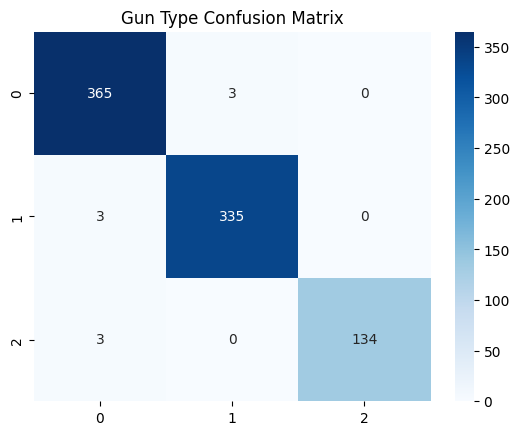

In [346]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_gun = confusion_matrix(y_gun_test, gun_type_pred)
sns.heatmap(cm_gun, annot=True, fmt='d', cmap='Blues')
plt.title("Gun Type Confusion Matrix")
plt.show()

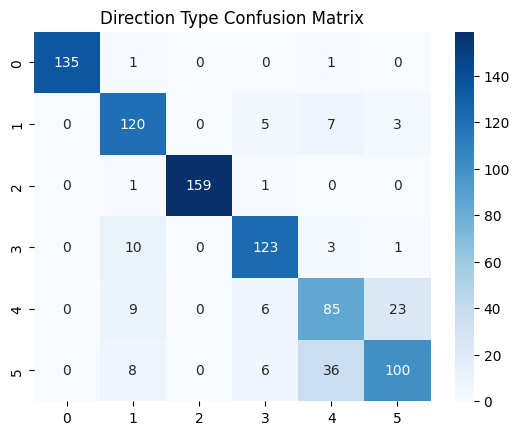

In [347]:
cm_direction = confusion_matrix(y_dir_test, direction_type_pred)
sns.heatmap(cm_direction, annot=True, fmt='d', cmap='Blues')
plt.title("Direction Type Confusion Matrix")
plt.show()

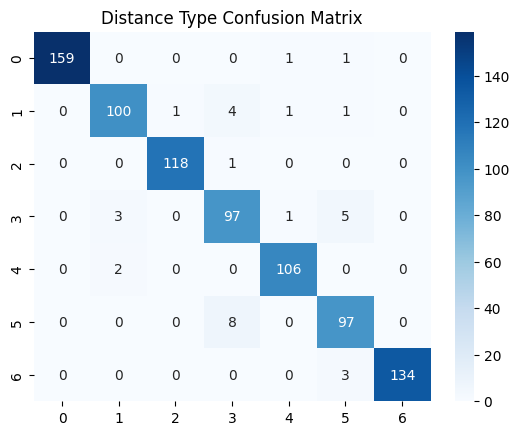

In [348]:
cm_distance = confusion_matrix(y_dist_test, distance_type_pred)
sns.heatmap(cm_distance, annot=True, fmt='d', cmap='Blues')
plt.title("Distance Type Confusion Matrix")
plt.show()

In [310]:
import plotly.graph_objects as go
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['gunshot_output_accuracy'],
                    name='Train'))
fig.add_trace(go.Scatter(
                    y=history.history['val_gunshot_output_accuracy'],
                    name='Valid'))
fig.update_layout(height=500, 
                  width=700,
                  title='Accuracy for gunshot feature',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')
fig.show()

<Figure size 640x480 with 0 Axes>

In [311]:
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['direction_output_accuracy'],
                    name='Train'))
fig.add_trace(go.Scatter(
                    y=history.history['val_direction_output_accuracy'],
                    name='Valid'))
fig.update_layout(height=500, 
                  width=700,
                  title='Accuracy for direction feature',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')
fig.show()

<Figure size 640x480 with 0 Axes>

In [312]:
plt.clf()
fig = go.Figure()
fig.add_trace(go.Scatter(
                    y=history.history['distance_output_accuracy'],
                    name='Train'))
fig.add_trace(go.Scatter(
                    y=history.history['val_distance_output_accuracy'],
                    name='Valid'))
fig.update_layout(height=500, 
                  width=700,
                  title='Accuracy for distance feature',
                  xaxis_title='Epoch',
                  yaxis_title='Accuracy')
fig.show()

<Figure size 640x480 with 0 Axes>

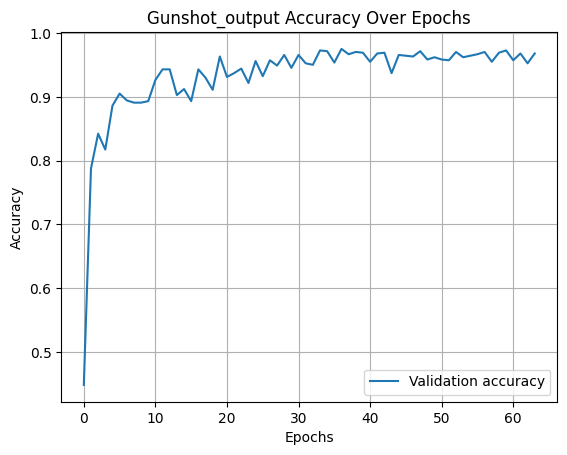

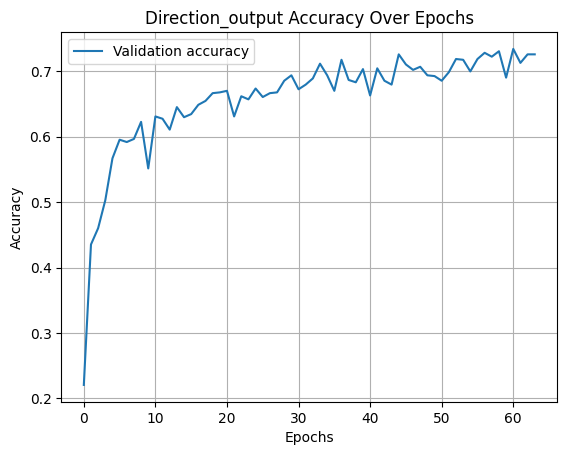

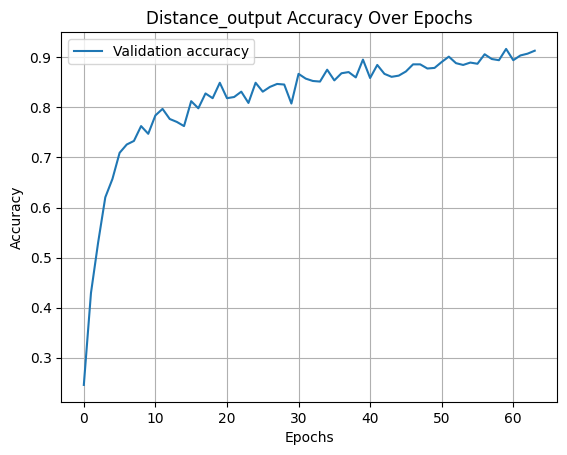

In [313]:
import matplotlib.pyplot as plt

def plot_training_history(history, model_name):
    metrics = ["accuracy"]
    for metric in metrics:

        plt.plot(
            history.history[f"val_{model_name}_{metric}"],
            label=f"Validation {metric}",
        )
        plt.title(f"{model_name.capitalize()} {metric.capitalize()} Over Epochs")
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid()
        plt.show()

# Plot training history for each output of the neural network
plot_training_history(history, "gunshot_output")
plot_training_history(history, "direction_output")
plot_training_history(history, "distance_output")


In [314]:
history_df = pd.DataFrame(history.history)
history_df.to_csv('model1.csv', index=False)